In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
import psycopg2

import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [195]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')

In [196]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()

In [197]:
start_dt = '2021-05-01'
end_dt = '2021-05-31'


heartbeat isn't rolled out for all carriers - false positives for dropoff
Disproven below:

In [332]:
heartbeat_query = """
select
    carrier
    , count(case when type = 'heartbeat' then 1 else NULL end) as heartbeat_events
    , count(*) as all_events
    , 100*count(case when type = 'heartbeat' then 1 else NULL end)/count(*) as pct_heartbeat
from audiences.dt_aud
where 
    right(tid,2) = '00'
    and date(t_created) >= '{start_dt}'
    and date(t_created) <= '{end_dt}'
group by 1
order by 3 desc
"""

heartbeat_df = bigquery_client.query(heartbeat_query.format(start_dt = start_dt, end_dt = end_dt)).to_dataframe()
heartbeat_df

carrier  heartbeat_events  all_events  pct_heartbeat
0       amxapk            162548     2764557       5.879712
1      samsung            194245      710188      27.351208
2      verizon            155769      383698      40.596771
3          att             41619      189034      22.016674
4      cricket             39338      176142      22.333118
5     tracfone             50669      145954      34.715732
6          blu             15750       45393      34.696980
7     millicom             17090       36952      46.249188
8   uscellular             13441       36842      36.482819
9       lenovo             13231       35755      37.004615
10       globe              6982       11775      59.295117
11      attmex              4312       11432      37.718684
12    reliance              4898        9559      51.239669
13         tim              7160        8527      83.968570
14      sliide              3947        7813      50.518367
15     myphone              3132        5525      56.687783
16     singtel              3227        5089      63.411279
17         zte              2560        2937      87.163773
18      archos              1232        2405      51.226611
19        acer               834        1784      46.748879
20   cloudfone              1057        1402      75.392297
21       intex               243         356      68.258427
22  telefonica               152         329      46.200608
23         pwg               119         155      76.774194
24      juliet                 4           8      50.000000

split by region 

find percent of all devices covered by top carriers

In [5]:
# choosing carriers
by_carrier_query = """
select
    c.c_name, 16*16*16*count(distinct imei) as devices
from rawdata.dt_process p 
join rawdata.rs_carrier c
    on p.rs_carrier_id = c.rs_carrier_id
where right(imei,3) = '000'
and date(startdate) >= '{start_dt}' 
and date(startdate) <= '{end_dt}'
group by 1
order by 2 desc
"""

cur_atlas.execute(by_carrier_query.format(start_dt = start_dt, end_dt = end_dt))
by_carrier_totals = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])
by_carrier_totals['sov'] = 100*by_carrier_totals['devices']/by_carrier_totals['devices'].sum()
by_carrier_totals.style.format({'devices':'{:,.0f}','sov':'{:,.1f}%'})

In [7]:
# k = 4

# last_seen_query = """
# select f_sha256_salt(t1.imei) as imei, rs_carrier_id, c_name, last_seen
# from
# (
#     select imei, p.rs_carrier_id, c.c_name, p.max(startdate) as last_seen
#     from rawdata.dt_process p 
#     join rawdata.rs_carrier c
#         on p.rs_carrier_id = c.rs_carrier_id
#         and c.c_name in ('AMXAPK','Tracfone','Cricket','Millicom','lava','ATT','Reliance','Verizon','USCellular')
#     where right(imei,2) = '0{n}'
#     and date(startdate) >= '2020-01-01' 
#     and date(startdate) <= '2020-03-16' -- max date in first_seens
#     group by 1,2,3
# ) t1
# left join 
# (
#     select imei
#     from rawdata.dt_process p 
#     join rawdata.rs_carrier c
#         on p.rs_carrier_id = c.rs_carrier_id
#         and c.c_name in ('AMXAPK','Tracfone','Cricket','Millicom','lava','ATT','Reliance','Verizon','USCellular')
#     where right(imei,2) = '0{n}'
#     and date(startdate) >= '2020-03-17' 
#     and date(startdate) <= '2020-04-16' -- 30d after last seen, filter out users with processes
#     group by 1
# ) t2
#     on t1.imei = t2.imei
# where t2.imei is null
# group by 1,2,3,4
# """

# last_seen_list = []
# for n in range(k):
#     print(f'Query {n+1} of {k}')
#     cur_atlas.execute(last_seen_query.format(n = n))
#     sub_df = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])
#     last_seen_list.append(sub_df)
# last_seen_df = pd.concat(last_seen_list)

Query 1 of 4
Query 2 of 4
Query 3 of 4
Query 4 of 4


In [8]:
# imei_list = last_seen_df.imei.unique()
# rs_carrier_list = last_seen_df.rs_carrier_id.unique()

In [15]:
# first_seen_query = """
# select f_sha256_salt(imei) as imei, rs_carrier_id, min(timestamp) as first_seen
# from rawdata.dt_first_seens
# where 
#     f_sha256_salt(imei) in {imei_sublist}
#     and rs_carrier_id in {rs_carrier_list}
#     and right(imei,2) = '0{n}'
#     and date(timestamp) >= date('2020-01-01') - interval '7 year'
#     and date(timestamp) <= '2020-03-16'
# group by 1,2
# """

# first_seen_list = []
# j = int(len(imei_list)/1000)+1
# for n in range(k):
#     for i in range(j):
    
#         imei_sublist = tuple(imei_list[i*1000: min(len(imei_list),(i+1)*1000)])

#         print(f'Running query {n*j+i+1} of {k*j}')
#         cur_atlas.execute(first_seen_query.format(start_dt = start_dt, end_dt = end_dt, n=n, imei_sublist = imei_sublist, rs_carrier_list = tuple(rs_carrier_list)))
#         sub_df = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])
#         first_seen_list.append(sub_df)

# first_seen_df = pd.concat(first_seen_list)

Running query 1 of 4624
Running query 2 of 4624
Running query 3 of 4624
Running query 4 of 4624
Running query 5 of 4624
Running query 6 of 4624
Running query 7 of 4624
Running query 8 of 4624
Running query 9 of 4624
Running query 10 of 4624
Running query 11 of 4624
Running query 12 of 4624
Running query 13 of 4624
Running query 14 of 4624
Running query 15 of 4624
Running query 16 of 4624
Running query 17 of 4624
Running query 18 of 4624
Running query 19 of 4624
Running query 20 of 4624
Running query 21 of 4624
Running query 22 of 4624
Running query 23 of 4624
Running query 24 of 4624
Running query 25 of 4624
Running query 26 of 4624
Running query 27 of 4624
Running query 28 of 4624
Running query 29 of 4624
Running query 30 of 4624
Running query 31 of 4624
Running query 32 of 4624
Running query 33 of 4624
Running query 34 of 4624
Running query 35 of 4624
Running query 36 of 4624
Running query 37 of 4624
Running query 38 of 4624
Running query 39 of 4624
Running query 40 of 4624
Running q

Running query 321 of 4624
Running query 322 of 4624
Running query 323 of 4624
Running query 324 of 4624
Running query 325 of 4624
Running query 326 of 4624
Running query 327 of 4624
Running query 328 of 4624
Running query 329 of 4624
Running query 330 of 4624
Running query 331 of 4624
Running query 332 of 4624
Running query 333 of 4624
Running query 334 of 4624
Running query 335 of 4624
Running query 336 of 4624
Running query 337 of 4624
Running query 338 of 4624
Running query 339 of 4624
Running query 340 of 4624
Running query 341 of 4624
Running query 342 of 4624
Running query 343 of 4624
Running query 344 of 4624
Running query 345 of 4624
Running query 346 of 4624
Running query 347 of 4624
Running query 348 of 4624
Running query 349 of 4624
Running query 350 of 4624
Running query 351 of 4624
Running query 352 of 4624
Running query 353 of 4624
Running query 354 of 4624
Running query 355 of 4624
Running query 356 of 4624
Running query 357 of 4624
Running query 358 of 4624
Running quer

Running query 637 of 4624
Running query 638 of 4624
Running query 639 of 4624
Running query 640 of 4624
Running query 641 of 4624
Running query 642 of 4624
Running query 643 of 4624
Running query 644 of 4624
Running query 645 of 4624
Running query 646 of 4624
Running query 647 of 4624
Running query 648 of 4624
Running query 649 of 4624
Running query 650 of 4624
Running query 651 of 4624
Running query 652 of 4624
Running query 653 of 4624
Running query 654 of 4624
Running query 655 of 4624
Running query 656 of 4624
Running query 657 of 4624
Running query 658 of 4624
Running query 659 of 4624
Running query 660 of 4624
Running query 661 of 4624
Running query 662 of 4624
Running query 663 of 4624
Running query 664 of 4624
Running query 665 of 4624
Running query 666 of 4624
Running query 667 of 4624
Running query 668 of 4624
Running query 669 of 4624
Running query 670 of 4624
Running query 671 of 4624
Running query 672 of 4624
Running query 673 of 4624
Running query 674 of 4624
Running quer

Running query 953 of 4624
Running query 954 of 4624
Running query 955 of 4624
Running query 956 of 4624
Running query 957 of 4624
Running query 958 of 4624
Running query 959 of 4624
Running query 960 of 4624
Running query 961 of 4624
Running query 962 of 4624
Running query 963 of 4624
Running query 964 of 4624
Running query 965 of 4624
Running query 966 of 4624
Running query 967 of 4624
Running query 968 of 4624
Running query 969 of 4624
Running query 970 of 4624
Running query 971 of 4624
Running query 972 of 4624
Running query 973 of 4624
Running query 974 of 4624
Running query 975 of 4624
Running query 976 of 4624
Running query 977 of 4624
Running query 978 of 4624
Running query 979 of 4624
Running query 980 of 4624
Running query 981 of 4624
Running query 982 of 4624
Running query 983 of 4624
Running query 984 of 4624
Running query 985 of 4624
Running query 986 of 4624
Running query 987 of 4624
Running query 988 of 4624
Running query 989 of 4624
Running query 990 of 4624
Running quer

Running query 1259 of 4624
Running query 1260 of 4624
Running query 1261 of 4624
Running query 1262 of 4624
Running query 1263 of 4624
Running query 1264 of 4624
Running query 1265 of 4624
Running query 1266 of 4624
Running query 1267 of 4624
Running query 1268 of 4624
Running query 1269 of 4624
Running query 1270 of 4624
Running query 1271 of 4624
Running query 1272 of 4624
Running query 1273 of 4624
Running query 1274 of 4624
Running query 1275 of 4624
Running query 1276 of 4624
Running query 1277 of 4624
Running query 1278 of 4624
Running query 1279 of 4624
Running query 1280 of 4624
Running query 1281 of 4624
Running query 1282 of 4624
Running query 1283 of 4624
Running query 1284 of 4624
Running query 1285 of 4624
Running query 1286 of 4624
Running query 1287 of 4624
Running query 1288 of 4624
Running query 1289 of 4624
Running query 1290 of 4624
Running query 1291 of 4624
Running query 1292 of 4624
Running query 1293 of 4624
Running query 1294 of 4624
Running query 1295 of 4624
R

Running query 1563 of 4624
Running query 1564 of 4624
Running query 1565 of 4624
Running query 1566 of 4624
Running query 1567 of 4624
Running query 1568 of 4624
Running query 1569 of 4624
Running query 1570 of 4624
Running query 1571 of 4624
Running query 1572 of 4624
Running query 1573 of 4624
Running query 1574 of 4624
Running query 1575 of 4624
Running query 1576 of 4624
Running query 1577 of 4624
Running query 1578 of 4624
Running query 1579 of 4624
Running query 1580 of 4624
Running query 1581 of 4624
Running query 1582 of 4624
Running query 1583 of 4624
Running query 1584 of 4624
Running query 1585 of 4624
Running query 1586 of 4624
Running query 1587 of 4624
Running query 1588 of 4624
Running query 1589 of 4624
Running query 1590 of 4624
Running query 1591 of 4624
Running query 1592 of 4624
Running query 1593 of 4624
Running query 1594 of 4624
Running query 1595 of 4624
Running query 1596 of 4624
Running query 1597 of 4624
Running query 1598 of 4624
Running query 1599 of 4624
R

Running query 1867 of 4624
Running query 1868 of 4624
Running query 1869 of 4624
Running query 1870 of 4624
Running query 1871 of 4624
Running query 1872 of 4624
Running query 1873 of 4624
Running query 1874 of 4624
Running query 1875 of 4624
Running query 1876 of 4624
Running query 1877 of 4624
Running query 1878 of 4624
Running query 1879 of 4624
Running query 1880 of 4624
Running query 1881 of 4624
Running query 1882 of 4624
Running query 1883 of 4624
Running query 1884 of 4624
Running query 1885 of 4624
Running query 1886 of 4624
Running query 1887 of 4624
Running query 1888 of 4624
Running query 1889 of 4624
Running query 1890 of 4624
Running query 1891 of 4624
Running query 1892 of 4624
Running query 1893 of 4624
Running query 1894 of 4624
Running query 1895 of 4624
Running query 1896 of 4624
Running query 1897 of 4624
Running query 1898 of 4624
Running query 1899 of 4624
Running query 1900 of 4624
Running query 1901 of 4624
Running query 1902 of 4624
Running query 1903 of 4624
R

Running query 2171 of 4624
Running query 2172 of 4624
Running query 2173 of 4624
Running query 2174 of 4624
Running query 2175 of 4624
Running query 2176 of 4624
Running query 2177 of 4624
Running query 2178 of 4624
Running query 2179 of 4624
Running query 2180 of 4624
Running query 2181 of 4624
Running query 2182 of 4624
Running query 2183 of 4624
Running query 2184 of 4624
Running query 2185 of 4624
Running query 2186 of 4624
Running query 2187 of 4624
Running query 2188 of 4624
Running query 2189 of 4624
Running query 2190 of 4624
Running query 2191 of 4624
Running query 2192 of 4624
Running query 2193 of 4624
Running query 2194 of 4624
Running query 2195 of 4624
Running query 2196 of 4624
Running query 2197 of 4624
Running query 2198 of 4624
Running query 2199 of 4624
Running query 2200 of 4624
Running query 2201 of 4624
Running query 2202 of 4624
Running query 2203 of 4624
Running query 2204 of 4624
Running query 2205 of 4624
Running query 2206 of 4624
Running query 2207 of 4624
R

Running query 2475 of 4624
Running query 2476 of 4624
Running query 2477 of 4624
Running query 2478 of 4624
Running query 2479 of 4624
Running query 2480 of 4624
Running query 2481 of 4624
Running query 2482 of 4624
Running query 2483 of 4624
Running query 2484 of 4624
Running query 2485 of 4624
Running query 2486 of 4624
Running query 2487 of 4624
Running query 2488 of 4624
Running query 2489 of 4624
Running query 2490 of 4624
Running query 2491 of 4624
Running query 2492 of 4624
Running query 2493 of 4624
Running query 2494 of 4624
Running query 2495 of 4624
Running query 2496 of 4624
Running query 2497 of 4624
Running query 2498 of 4624
Running query 2499 of 4624
Running query 2500 of 4624
Running query 2501 of 4624
Running query 2502 of 4624
Running query 2503 of 4624
Running query 2504 of 4624
Running query 2505 of 4624
Running query 2506 of 4624
Running query 2507 of 4624
Running query 2508 of 4624
Running query 2509 of 4624
Running query 2510 of 4624
Running query 2511 of 4624
R

Running query 2779 of 4624
Running query 2780 of 4624
Running query 2781 of 4624
Running query 2782 of 4624
Running query 2783 of 4624
Running query 2784 of 4624
Running query 2785 of 4624
Running query 2786 of 4624
Running query 2787 of 4624
Running query 2788 of 4624
Running query 2789 of 4624
Running query 2790 of 4624
Running query 2791 of 4624
Running query 2792 of 4624
Running query 2793 of 4624
Running query 2794 of 4624
Running query 2795 of 4624
Running query 2796 of 4624
Running query 2797 of 4624
Running query 2798 of 4624
Running query 2799 of 4624
Running query 2800 of 4624
Running query 2801 of 4624
Running query 2802 of 4624
Running query 2803 of 4624
Running query 2804 of 4624
Running query 2805 of 4624
Running query 2806 of 4624
Running query 2807 of 4624
Running query 2808 of 4624
Running query 2809 of 4624
Running query 2810 of 4624
Running query 2811 of 4624
Running query 2812 of 4624
Running query 2813 of 4624
Running query 2814 of 4624
Running query 2815 of 4624
R

Running query 3083 of 4624
Running query 3084 of 4624
Running query 3085 of 4624
Running query 3086 of 4624
Running query 3087 of 4624
Running query 3088 of 4624
Running query 3089 of 4624
Running query 3090 of 4624
Running query 3091 of 4624
Running query 3092 of 4624
Running query 3093 of 4624
Running query 3094 of 4624
Running query 3095 of 4624
Running query 3096 of 4624
Running query 3097 of 4624
Running query 3098 of 4624
Running query 3099 of 4624
Running query 3100 of 4624
Running query 3101 of 4624
Running query 3102 of 4624
Running query 3103 of 4624
Running query 3104 of 4624
Running query 3105 of 4624
Running query 3106 of 4624
Running query 3107 of 4624
Running query 3108 of 4624
Running query 3109 of 4624
Running query 3110 of 4624
Running query 3111 of 4624
Running query 3112 of 4624
Running query 3113 of 4624
Running query 3114 of 4624
Running query 3115 of 4624
Running query 3116 of 4624
Running query 3117 of 4624
Running query 3118 of 4624
Running query 3119 of 4624
R

Running query 3387 of 4624
Running query 3388 of 4624
Running query 3389 of 4624
Running query 3390 of 4624
Running query 3391 of 4624
Running query 3392 of 4624
Running query 3393 of 4624
Running query 3394 of 4624
Running query 3395 of 4624
Running query 3396 of 4624
Running query 3397 of 4624
Running query 3398 of 4624
Running query 3399 of 4624
Running query 3400 of 4624
Running query 3401 of 4624
Running query 3402 of 4624
Running query 3403 of 4624
Running query 3404 of 4624
Running query 3405 of 4624
Running query 3406 of 4624
Running query 3407 of 4624
Running query 3408 of 4624
Running query 3409 of 4624
Running query 3410 of 4624
Running query 3411 of 4624
Running query 3412 of 4624
Running query 3413 of 4624
Running query 3414 of 4624
Running query 3415 of 4624
Running query 3416 of 4624
Running query 3417 of 4624
Running query 3418 of 4624
Running query 3419 of 4624
Running query 3420 of 4624
Running query 3421 of 4624
Running query 3422 of 4624
Running query 3423 of 4624
R

Running query 3691 of 4624
Running query 3692 of 4624
Running query 3693 of 4624
Running query 3694 of 4624
Running query 3695 of 4624
Running query 3696 of 4624
Running query 3697 of 4624
Running query 3698 of 4624
Running query 3699 of 4624
Running query 3700 of 4624
Running query 3701 of 4624
Running query 3702 of 4624
Running query 3703 of 4624
Running query 3704 of 4624
Running query 3705 of 4624
Running query 3706 of 4624
Running query 3707 of 4624
Running query 3708 of 4624
Running query 3709 of 4624
Running query 3710 of 4624
Running query 3711 of 4624
Running query 3712 of 4624
Running query 3713 of 4624
Running query 3714 of 4624
Running query 3715 of 4624
Running query 3716 of 4624
Running query 3717 of 4624
Running query 3718 of 4624
Running query 3719 of 4624
Running query 3720 of 4624
Running query 3721 of 4624
Running query 3722 of 4624
Running query 3723 of 4624
Running query 3724 of 4624
Running query 3725 of 4624
Running query 3726 of 4624
Running query 3727 of 4624
R

Running query 3995 of 4624
Running query 3996 of 4624
Running query 3997 of 4624
Running query 3998 of 4624
Running query 3999 of 4624
Running query 4000 of 4624
Running query 4001 of 4624
Running query 4002 of 4624
Running query 4003 of 4624
Running query 4004 of 4624
Running query 4005 of 4624
Running query 4006 of 4624
Running query 4007 of 4624
Running query 4008 of 4624
Running query 4009 of 4624
Running query 4010 of 4624
Running query 4011 of 4624
Running query 4012 of 4624
Running query 4013 of 4624
Running query 4014 of 4624
Running query 4015 of 4624
Running query 4016 of 4624
Running query 4017 of 4624
Running query 4018 of 4624
Running query 4019 of 4624
Running query 4020 of 4624
Running query 4021 of 4624
Running query 4022 of 4624
Running query 4023 of 4624
Running query 4024 of 4624
Running query 4025 of 4624
Running query 4026 of 4624
Running query 4027 of 4624
Running query 4028 of 4624
Running query 4029 of 4624
Running query 4030 of 4624
Running query 4031 of 4624
R

Running query 4299 of 4624
Running query 4300 of 4624
Running query 4301 of 4624
Running query 4302 of 4624
Running query 4303 of 4624
Running query 4304 of 4624
Running query 4305 of 4624
Running query 4306 of 4624
Running query 4307 of 4624
Running query 4308 of 4624
Running query 4309 of 4624
Running query 4310 of 4624
Running query 4311 of 4624
Running query 4312 of 4624
Running query 4313 of 4624
Running query 4314 of 4624
Running query 4315 of 4624
Running query 4316 of 4624
Running query 4317 of 4624
Running query 4318 of 4624
Running query 4319 of 4624
Running query 4320 of 4624
Running query 4321 of 4624
Running query 4322 of 4624
Running query 4323 of 4624
Running query 4324 of 4624
Running query 4325 of 4624
Running query 4326 of 4624
Running query 4327 of 4624
Running query 4328 of 4624
Running query 4329 of 4624
Running query 4330 of 4624
Running query 4331 of 4624
Running query 4332 of 4624
Running query 4333 of 4624
Running query 4334 of 4624
Running query 4335 of 4624
R

Running query 4603 of 4624
Running query 4604 of 4624
Running query 4605 of 4624
Running query 4606 of 4624
Running query 4607 of 4624
Running query 4608 of 4624
Running query 4609 of 4624
Running query 4610 of 4624
Running query 4611 of 4624
Running query 4612 of 4624
Running query 4613 of 4624
Running query 4614 of 4624
Running query 4615 of 4624
Running query 4616 of 4624
Running query 4617 of 4624
Running query 4618 of 4624
Running query 4619 of 4624
Running query 4620 of 4624
Running query 4621 of 4624
Running query 4622 of 4624
Running query 4623 of 4624
Running query 4624 of 4624


In [16]:
# joined_df = last_seen_df.set_index(['imei', 'rs_carrier_id']).join(first_seen_df.set_index(['imei', 'rs_carrier_id']), how = 'left')
# joined_df.reset_index(inplace = True)
# joined_df

imei  rs_carrier_id  \
0        00002593c5f35fe29acce328dff9b1bff86b546bed033             44   
1        00004bbdb5efb015e2eaaf063b23c09eb9690e737648a             44   
2        000061b14a6b1dbdf9189cffbbfab273035410a328a5b              8   
3        000063a4da9552cde1dd515f08d64a6d5a1682e13b39b             44   
4        00008354b3f16deb500b201382fe5246fa47349792f97             44   
...                                                ...            ...   
1156116  ffffca7a984152a749fa1b17db302c5be1ec55bd9dae0             44   
1156117  ffffdda397643a40d7039c4dafa77dd67a40ce9a6f306             44   
1156118  ffffe320a9356fbc289c934bf60366e3c534b9a242d65             44   
1156119  fffff521606fa863a02a9e828492a7ffa89628e082e60             44   
1156120  fffffa96c4b1c811a4478149c1993388866742c4a3fe9             44   

           c_name           last_seen          first_seen  
0          AMXAPK 2020-01-30 02:23:08                 NaT  
1          AMXAPK 2020-01-15 19:20:20 2016-12-14 02:43:03  
2        Millicom 2020-01-03 16:09:25                 NaT  
3          AMXAPK 2020-02-20 00:50:28                 NaT  
4          AMXAPK 2020-02-08 00:02:49                 NaT  
...           ...                 ...                 ...  
1156116    AMXAPK 2020-01-26 23:57:39                 NaT  
1156117    AMXAPK 2020-03-01 18:04:23                 NaT  
1156118    AMXAPK 2020-03-09 06:29:40                 NaT  
1156119    AMXAPK 2020-02-17 14:50:05                 NaT  
1156120    AMXAPK 2020-01-08 23:36:52                 NaT  

[1156121 rows x 5 columns]

In [52]:
# joined_df['c_name'] = joined_df['c_name'].str.lower()
# joined_df

imei  rs_carrier_id  \
0        00002593c5f35fe29acce328dff9b1bff86b546bed033             44   
1        00004bbdb5efb015e2eaaf063b23c09eb9690e737648a             44   
2        000061b14a6b1dbdf9189cffbbfab273035410a328a5b              8   
3        000063a4da9552cde1dd515f08d64a6d5a1682e13b39b             44   
4        00008354b3f16deb500b201382fe5246fa47349792f97             44   
...                                                ...            ...   
1156116  ffffca7a984152a749fa1b17db302c5be1ec55bd9dae0             44   
1156117  ffffdda397643a40d7039c4dafa77dd67a40ce9a6f306             44   
1156118  ffffe320a9356fbc289c934bf60366e3c534b9a242d65             44   
1156119  fffff521606fa863a02a9e828492a7ffa89628e082e60             44   
1156120  fffffa96c4b1c811a4478149c1993388866742c4a3fe9             44   

           c_name           last_seen          first_seen           lifetime  \
0          amxapk 2020-01-30 02:23:08                 NaT                NaT   
1          amxapk 2020-01-15 19:20:20 2016-12-14 02:43:03 1127 days 16:37:17   
2        millicom 2020-01-03 16:09:25                 NaT                NaT   
3          amxapk 2020-02-20 00:50:28                 NaT                NaT   
4          amxapk 2020-02-08 00:02:49                 NaT                NaT   
...           ...                 ...                 ...                ...   
1156116    amxapk 2020-01-26 23:57:39                 NaT                NaT   
1156117    amxapk 2020-03-01 18:04:23                 NaT                NaT   
1156118    amxapk 2020-03-09 06:29:40                 NaT                NaT   
1156119    amxapk 2020-02-17 14:50:05                 NaT                NaT   
1156120    amxapk 2020-01-08 23:36:52                 NaT                NaT   

         imei_dashed  
0              False  
1              False  
2              False  
3              False  
4              False  
...              ...  
1156116        False  
1156117        False  
1156118        False  
1156119        False  
1156120        False  

[1156121 rows x 7 columns]

In [17]:
# joined_df.isna().sum()

imei                  0
rs_carrier_id         0
c_name                0
last_seen             0
first_seen       740553
dtype: int64

In [6]:
# joined_df.to_csv('files/ignite_lifetimes_method1.csv', index = False)
# joined_df = pd.read_csv('files/ignite_lifetimes_method1.csv')

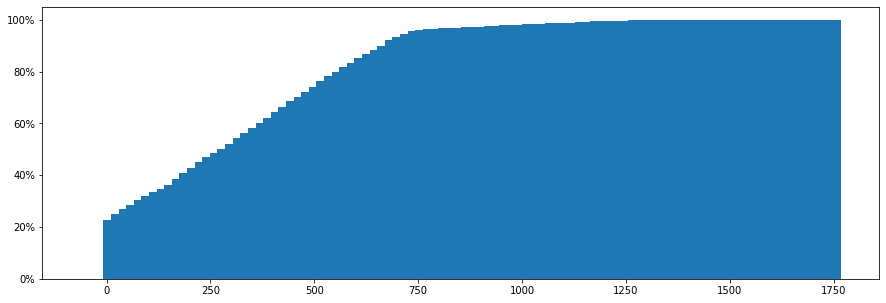

In [10]:
# joined_df['lifetime'] = pd.to_datetime(joined_df['last_seen']) - pd.to_datetime(joined_df['first_seen'])
# plt.figure(figsize = (15,5))
# plt.hist(joined_df['lifetime'].astype('timedelta64[D]'), bins = 100, cumulative = True, density = True)
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

In [11]:
# joined_df['imei_dashed'] = joined_df['imei'].str.contains('-')
# joined_df.pivot_table(values = ['first_seen','last_seen'], index = 'imei_dashed', aggfunc = 'count')

first_seen  last_seen
imei_dashed                       
False            414678    1152396
True                890       3725

In [12]:
# by_carrier = joined_df.pivot_table(values = ['first_seen','last_seen'], index = 'c_name', aggfunc = 'count')
# by_carrier['unmatched'] = by_carrier['last_seen'] - by_carrier['first_seen']
# by_carrier['match_rate'] = by_carrier['first_seen']/by_carrier['last_seen']
# by_carrier.sort_values(['unmatched'], ascending = False, inplace = True)
# carriers = by_carrier[by_carrier.match_rate > .6].index.tolist()

# by_carrier

first_seen  last_seen  unmatched  match_rate
c_name                                                  
amxapk           55216     605761     550545    0.091151
verizon         202004     274400      72396    0.736166
millicom          5604      58467      52863    0.095849
reliance          2669      26973      24304    0.098951
lava              1524      17617      16093    0.086507
cricket          66073      77308      11235    0.854672
att              36504      41384       4880    0.882080
uscellular        9824      14119       4295    0.695800
tracfone         36150      40092       3942    0.901676

In [14]:
# by_carrier = joined_df.pivot_table(values = ['first_seen','last_seen'], index = 'c_name', columns = 'imei_dashed', aggfunc = 'count', margins = True)
# by_carrier['match_rate'] = by_carrier[('first_seen','All')]/by_carrier[('last_seen','All')]
# by_carrier.sort_values([('first_seen','All')], ascending = False, inplace = True)
# by_carrier

first_seen                last_seen                 match_rate
imei_dashed      False   True     All     False    True     All           
c_name                                                                    
All           414678.0  890.0  415568  414678.0   890.0  415568        1.0
verizon       201460.0  544.0  202004  272292.0  2108.0  202004        1.0
cricket        65955.0  118.0   66073   76475.0   833.0   66073        1.0
amxapk         55216.0    NaN   55216  605761.0     NaN   55216        1.0
att            36307.0  197.0   36504   40758.0   626.0   36504        1.0
tracfone       36150.0    NaN   36150   40092.0     NaN   36150        1.0
uscellular      9793.0   31.0    9824   13961.0   158.0    9824        1.0
millicom        5604.0    NaN    5604   58467.0     NaN    5604        1.0
reliance        2669.0    NaN    2669   26973.0     NaN    2669        1.0
lava            1524.0    NaN    1524   17617.0     NaN    1524        1.0

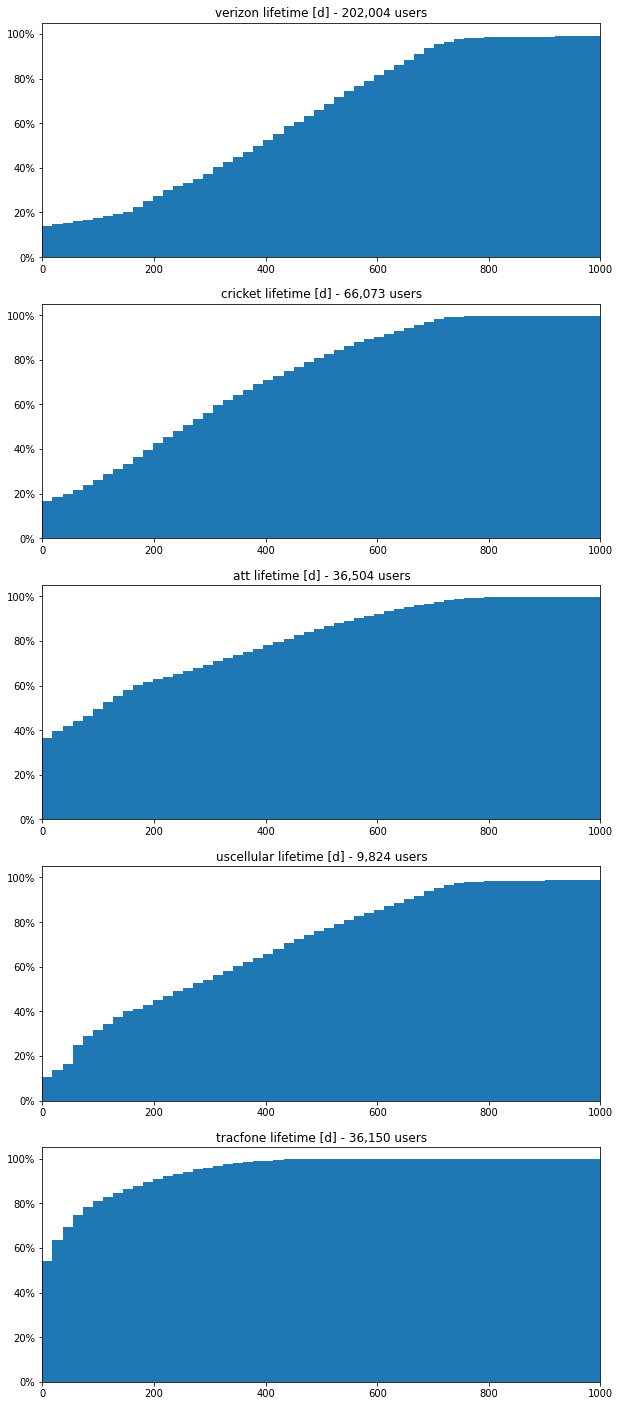

In [15]:
# fig, ax = plt.subplots(len(carriers), 1, figsize = (10,5*len(carriers)))

# for i in list(range(len(carriers))):
#     carrier = carriers[i]
#     filtered_lifetime = joined_df.loc[joined_df.c_name == carrier, 'lifetime']
#     ax[i].set_title('{} lifetime [d] - {:,.0f} devices'.format(carrier, filtered_lifetime.count()))
#     try:
#         ax[i].hist(filtered_lifetime.astype('timedelta64[D]'), bins = 100, cumulative = True, density = True, range = [0,1800])
#     except:
#         print(f'ERROR with {carrier}')
#     ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(1))
#     ax[i].set_xlim([0,1000])

In [7]:
uevents_carriers = ['samsung','verizon','cricket','att','amxapk','tracfone','lava','uscellular','blu','lenovo'] #

In [6]:
last_seen_list = [pd.read_csv('~/files/last_seen_lenovo.csv')]

In [10]:
k2=4
last_seen_uevents_query = """
select t1.dtid, country, '{carrier}' as c_name, last_seen
from
(
    select dtid, max(receivedtimestamp) as last_seen, max(countrycode) as country
    from {carrier}_rawdata.event e
    where right(dtid,2) = '0{n}'
    and date(receivedtimestamp) >= '{start_dt}' 
    and date(receivedtimestamp) <= '{end_dt}'
    group by 1
) t1 
left join
(
    select dtid
    from {carrier}_rawdata.event e
    where right(dtid,2) = '0{n}'
    and date(receivedtimestamp) >= '{end_dt}' + 1 
    and date(receivedtimestamp) <= '{end_dt}' + 30
    group by 1
) t2
    on t1.dtid = t2.dtid
where t2.dtid is null
group by 1,2,4
"""
try:
    print('length of last seen list:', len(last_seen_list))
except:
    last_seen_list = []

for carrier in uevents_carriers:
    for n in range(k2):
        if carrier == 'samsung' and n > 0: #Samsung has a lot more dtids than rest
            continue
        print('Running query for',carrier,f'- {n+1} of {k2}')
        cur_atlas.execute(last_seen_uevents_query.format(start_dt = start_dt, end_dt = end_dt, carrier = carrier, n=n))
        sub_df = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])
        last_seen_list.append(sub_df)
    
    pd.concat(last_seen_list).to_csv(f'~/files/last_seen_{carrier}.csv', index = False)

last_seen_df = pd.concat(last_seen_list)

length of last seen list: 1
Running query for verizon - 1 of 4
Running query for verizon - 2 of 4
Running query for verizon - 3 of 4
Running query for verizon - 4 of 4
Running query for cricket - 1 of 4
Running query for cricket - 2 of 4
Running query for cricket - 3 of 4
Running query for cricket - 4 of 4
Running query for att - 1 of 4
Running query for att - 2 of 4
Running query for att - 3 of 4
Running query for att - 4 of 4
Running query for amxapk - 1 of 4
Running query for amxapk - 2 of 4
Running query for amxapk - 3 of 4
Running query for amxapk - 4 of 4
Running query for tracfone - 1 of 4
Running query for tracfone - 2 of 4
Running query for tracfone - 3 of 4
Running query for tracfone - 4 of 4
Running query for lava - 1 of 4
Running query for lava - 2 of 4
Running query for lava - 3 of 4
Running query for lava - 4 of 4
Running query for uscellular - 1 of 4
Running query for uscellular - 2 of 4
Running query for uscellular - 3 of 4
Running query for uscellular - 4 of 4
Running 

In [9]:
last_seen_df = pd.read_csv(f'~/notebooks/files/last_seen_{uevents_carriers[-1]}.csv')

In [10]:
# store lists of dtids for each carrier in a dict 
dtid_dict = {}
uevents_carriers = ['samsung','verizon','cricket','att','amxapk','tracfone','lava','uscellular','blu','lenovo'] 
for carrier in uevents_carriers:
    dtid_carrier_list = last_seen_df.loc[last_seen_df.c_name == carrier, 'dtid'].drop_duplicates().tolist()
    dtid_dict[carrier] = dtid_carrier_list

In [56]:
first_seen_uevents_query = """
select dtid, '{carrier}' as c_name, min(receivedtimestamp) as first_seen
from {carrier}_rawdata.event e
where 
    dtid in {dtid_sublist}
    and date(receivedtimestamp) >= date('{start_dt}') - interval '7 year'
    and date(receivedtimestamp) <= '{end_dt}'
group by 1
"""

first_seen_list_len = first_seen_list[0].c_name.unique().shape[0]
try:
    print('length of first seen list:', first_seen_list_len)
except:
    first_seen_list = []

for carrier in uevents_carriers[first_seen_list_len-1:]: #remove -1 if you want to continue
    dtid_list = dtid_dict[carrier]
    
    for i in list(range(int(len(dtid_list)/1000)+1)):
        if carrier == 'amxapk' and i < 67: # continue from where i left off
            continue
            
        dtid_sublist = tuple(dtid_list[i*1000: min(len(dtid_list),(i+1)*1000)])

        print(f'{carrier} - Running query {i+1} of {int(len(dtid_list)/1000)+1}')
        cur_atlas.execute(first_seen_uevents_query.format(start_dt = start_dt, end_dt = end_dt, carrier = carrier, dtid_sublist = dtid_sublist))
        sub_df = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])
        first_seen_list.append(sub_df)
       
    pd.concat(first_seen_list).to_csv(f'~/files/first_seen_{carrier}.csv', index = False)

first_seen_df = pd.concat(first_seen_list)

length of first seen list: 5
amxapk - Running query 68 of 86
amxapk - Running query 69 of 86
amxapk - Running query 70 of 86
amxapk - Running query 71 of 86
amxapk - Running query 72 of 86
amxapk - Running query 73 of 86
amxapk - Running query 74 of 86
amxapk - Running query 75 of 86
amxapk - Running query 76 of 86
amxapk - Running query 77 of 86
amxapk - Running query 78 of 86
amxapk - Running query 79 of 86
amxapk - Running query 80 of 86
amxapk - Running query 81 of 86
amxapk - Running query 82 of 86
amxapk - Running query 83 of 86
amxapk - Running query 84 of 86
amxapk - Running query 85 of 86
amxapk - Running query 86 of 86
tracfone - Running query 1 of 31
tracfone - Running query 2 of 31
tracfone - Running query 3 of 31
tracfone - Running query 4 of 31
tracfone - Running query 5 of 31
tracfone - Running query 6 of 31
tracfone - Running query 7 of 31
tracfone - Running query 8 of 31
tracfone - Running query 9 of 31
tracfone - Running query 10 of 31
tracfone - Running query 11 of 3

In [57]:
pd.concat(first_seen_list).to_csv(f'~/files/first_seen_{carrier}.csv', index = False)

In [11]:
first_seen_df = pd.read_csv(f'~/notebooks/files/first_seen_{uevents_carriers[-1]}.csv')

In [86]:
joined_dtid_df = last_seen_df.set_index(['dtid', 'c_name']).join(first_seen_df.set_index(['dtid', 'c_name']), how = 'left')
joined_dtid_df.reset_index(inplace = True)
joined_dtid_df

dtid   c_name country  \
0       02779f583a86323bba942f9d5a19e221c9b846b0e2ffec...  samsung      br   
1       629748213d9f271116aedd2516ec744763b9894d2eb01f...  samsung      br   
2       72de4a7e72117505fa6375ea5f6e51069879d4f3252a4e...  samsung      jm   
3       74b946442d41348b7b38d1c4c91c1b59c77a951babbf7e...  samsung      br   
4       c7390fed725ac6527551652e0a19e70f7e36822cf9f85b...  samsung      sa   
...                                                   ...      ...     ...   
258230  25799274b305607e606cea194d6d1f21fef6f119811afa...   lenovo      ru   
258231  7ed17f969a239161f26a98574181f1f98acd044e43dd06...   lenovo      ir   
258232  70b554b8d63e6d96f97b04102ca06ae8f929eff1a603a3...   lenovo     NaN   
258233  3afeaec86a1aa83927645bb7727788e31fb9dbafccde67...   lenovo      in   
258234  3711438f9b759edcecf0dc397027de74b638c065ecd15d...   lenovo      es   

                         last_seen                  first_seen  
0          2021-05-20 11:18:50.008     2021-05-20 09:55:29.442  
1          2021-05-25 23:09:44.309     2021-05-25 22:28:06.013  
2          2021-05-27 06:16:39.278     2021-02-02 02:29:22.905  
3          2021-05-25 22:29:19.670     2020-11-11 22:09:00.511  
4          2021-05-08 19:06:32.747     2021-05-08 17:17:05.679  
...                            ...                         ...  
258230  2021-05-22 17:30:03.717000  2019-09-02 16:18:28.822000  
258231  2021-05-22 08:48:02.146000  2020-08-16 18:19:54.492000  
258232  2021-05-28 13:22:00.900000  2020-08-08 00:19:22.153000  
258233  2021-05-30 22:26:16.658000  2021-05-30 22:26:16.658000  
258234  2021-05-15 08:32:36.546000  2021-04-07 19:53:06.027000  

[258235 rows x 5 columns]

In [87]:
joined_dtid_df.isna().sum()

dtid             0
c_name           0
country       7472
last_seen        0
first_seen    2000
dtype: int64

In [88]:
pd.DataFrame([joined_dtid_df.loc[joined_dtid_df.first_seen.isna()].groupby('c_name')['dtid'].count(),joined_dtid_df.loc[~joined_dtid_df.first_seen.isna()].groupby('c_name')['dtid'].count()]).transpose()

dtid     dtid
c_name                     
amxapk      2000.0  83238.0
att            NaN  26735.0
blu            NaN   6964.0
cricket        NaN  18510.0
lava           NaN   2885.0
lenovo         NaN  17676.0
samsung        NaN  29085.0
tracfone       NaN  30354.0
uscellular     NaN   3318.0
verizon        NaN  37470.0

In [89]:
by_carrier = joined_dtid_df.pivot_table(values = ['first_seen','last_seen'], index = 'c_name', aggfunc = 'count')
by_carrier

first_seen  last_seen
c_name                           
amxapk           83238      85238
att              26735      26735
blu               6964       6964
cricket          18510      18510
lava              2885       2885
lenovo           17676      17676
samsung          29085      29085
tracfone         30354      30354
uscellular        3318       3318
verizon          37470      37470

In [325]:
by_country = joined_dtid_df.pivot_table(values = ['first_seen','last_seen'], index = 'country', aggfunc = 'count')
by_country.sort_values('last_seen', ascending = False).head(30)

first_seen  last_seen
country                       
us           109323     109402
mx            50103      51213
br            16917      16988
co            10860      11080
pe             6889       7028
in             6068       6068
ar             3769       3845
cl             2747       2799
ir             2385       2385
do             2115       2140
gt             2027       2061
ve             1859       1869
ec             1720       1738
eg             1731       1731
hn             1429       1447
tr             1315       1316
pk             1313       1313
sv             1231       1248
sa             1198       1198
jm             1176       1176
iq             1136       1136
ye             1121       1121
ni             1008       1016
gb              900        900
es              829        830
cu              813        814
pr              614        627
ru              623        623
fr              621        621
de              550        550

In [330]:
by_country_sov = 100*joined_dtid_df['country'].value_counts(normalize=True).to_frame()
by_country_sov.columns = ['sov']
by_country_sov['cum_sov'] = by_country_sov.sov.cumsum()
by_country_sov.style.format('{:,.1f}%')

In [90]:
joined_dtid_df['last_seen'] = pd.to_datetime(joined_dtid_df.last_seen)
joined_dtid_df['first_seen'] = pd.to_datetime(joined_dtid_df.first_seen)
joined_dtid_df['lifetime'] = joined_dtid_df['last_seen'] - joined_dtid_df['first_seen']
joined_dtid_df

dtid   c_name country  \
0       02779f583a86323bba942f9d5a19e221c9b846b0e2ffec...  samsung      br   
1       629748213d9f271116aedd2516ec744763b9894d2eb01f...  samsung      br   
2       72de4a7e72117505fa6375ea5f6e51069879d4f3252a4e...  samsung      jm   
3       74b946442d41348b7b38d1c4c91c1b59c77a951babbf7e...  samsung      br   
4       c7390fed725ac6527551652e0a19e70f7e36822cf9f85b...  samsung      sa   
...                                                   ...      ...     ...   
258230  25799274b305607e606cea194d6d1f21fef6f119811afa...   lenovo      ru   
258231  7ed17f969a239161f26a98574181f1f98acd044e43dd06...   lenovo      ir   
258232  70b554b8d63e6d96f97b04102ca06ae8f929eff1a603a3...   lenovo     NaN   
258233  3afeaec86a1aa83927645bb7727788e31fb9dbafccde67...   lenovo      in   
258234  3711438f9b759edcecf0dc397027de74b638c065ecd15d...   lenovo      es   

                     last_seen              first_seen  \
0      2021-05-20 11:18:50.008 2021-05-20 09:55:29.442   
1      2021-05-25 23:09:44.309 2021-05-25 22:28:06.013   
2      2021-05-27 06:16:39.278 2021-02-02 02:29:22.905   
3      2021-05-25 22:29:19.670 2020-11-11 22:09:00.511   
4      2021-05-08 19:06:32.747 2021-05-08 17:17:05.679   
...                        ...                     ...   
258230 2021-05-22 17:30:03.717 2019-09-02 16:18:28.822   
258231 2021-05-22 08:48:02.146 2020-08-16 18:19:54.492   
258232 2021-05-28 13:22:00.900 2020-08-08 00:19:22.153   
258233 2021-05-30 22:26:16.658 2021-05-30 22:26:16.658   
258234 2021-05-15 08:32:36.546 2021-04-07 19:53:06.027   

                       lifetime  
0        0 days 01:23:20.566000  
1        0 days 00:41:38.296000  
2      114 days 03:47:16.373000  
3      195 days 00:20:19.159000  
4        0 days 01:49:27.068000  
...                         ...  
258230 628 days 01:11:34.895000  
258231 278 days 14:28:07.654000  
258232 293 days 13:02:38.747000  
258233          0 days 00:00:00  
258234  37 days 12:39:30.519000  

[258235 rows x 6 columns]

In [198]:
first_timestamp_query = "select '{carrier}' as c_name, min(receivedtimestamp) as first_ts from {carrier}_rawdata.event"
min_timestamps = pd.DataFrame()
for carrier in uevents_carriers:
    print('Running query for',carrier)
    cur_atlas.execute(first_timestamp_query.format(carrier = carrier))
    sub_df = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])
    min_timestamps = min_timestamps.append(sub_df)
min_timestamps['diff_with_5_1'] = min_timestamps.first_ts - datetime.datetime(2021,5,1,0,0,0)
min_timestamps

Running query for samsung
Running query for verizon
Running query for cricket
Running query for att
Running query for amxapk
Running query for tracfone
Running query for lava
Running query for uscellular
Running query for blu
Running query for lenovo


In [229]:
min_timestamps

carrier                first_ts               diff_with_5_1
0     samsung 2019-01-25 22:28:40.626  -827 days +22:28:40.626000
0     verizon 2018-05-09 00:00:00.072 -1088 days +00:00:00.072000
0     cricket 2018-10-01 00:00:00.110  -943 days +00:00:00.110000
0         att 2018-10-01 00:00:00.473  -943 days +00:00:00.473000
0      amxapk 2018-11-09 20:46:40.275  -904 days +20:46:40.275000
0    tracfone 2018-10-01 00:01:00.618  -943 days +00:01:00.618000
0        lava 2019-03-27 01:24:35.175  -766 days +01:24:35.175000
0  uscellular 2018-09-24 00:00:00.120  -950 days +00:00:00.120000
0         blu 2018-09-03 00:00:02.003  -971 days +00:00:02.003000
0      lenovo 2018-09-24 00:00:00.804  -950 days +00:00:00.804000

In [264]:
joined_dtid_df_mins = joined_dtid_df.set_index('c_name').join(min_timestamps.set_index('carrier'), how = 'left').reset_index()
joined_dtid_df_mins.rename(columns = {'index':'c_name'}, inplace = True)
joined_dtid_df_mins['days_after_min'] = joined_dtid_df_mins.first_seen - joined_dtid_df_mins.first_ts

days_after_min_filter = joined_dtid_df_mins.days_after_min < datetime.timedelta(days=90)
tail_by_carrier = joined_dtid_df_mins[days_after_min_filter].groupby('c_name')['lifetime'].min().dt.days
tail_by_carrier = tail_by_carrier.to_frame().join(by_carrier)
tail_by_carrier['weighted_lifetime'] = tail_by_carrier['lifetime']*tail_by_carrier['first_seen']
tail_by_carrier


lifetime  first_seen  last_seen  weighted_lifetime
c_name                                                        
amxapk           813       83238      85238           67672494
att              855       26735      26735           22858425
blu              897        6964       6964            6246708
cricket          855       18510      18510           15826050
lava             686        2885       2885            1979110
lenovo           867       17676      17676           15325092
samsung          767       29085      29085           22308195
tracfone         855       30354      30354           25952670
uscellular       864        3318       3318            2866752
verizon         1087       37470      37470           40729890

Samsung BR (late 2019 silent launch)

In [287]:
tail_by_country = joined_dtid_df_mins[days_after_min_filter].groupby('country')['lifetime'].min().dt.days
tail_by_country = tail_by_country.to_frame().join(by_country)
tail_by_country['weighted_lifetime'] = tail_by_country['lifetime']*tail_by_country['first_seen']
tail_by_country.sort_values('last_seen', ascending = False)


lifetime  first_seen  last_seen  weighted_lifetime
country                                                    
us            814      109323     109402           88988922
mx            814       50103      51213           40783842
br            814       16917      16988           13770438
co            815       10860      11080            8850900
pe            813        6889       7028            5600757
...           ...         ...        ...                ...
fm            908           9          9               8172
bi            916           8          8               7328
bj            925           7          7               6475
kn            939           4          4               3756
vc            957           3          3               2871

[109 rows x 4 columns]

In [17]:
# Combine these method 2 carriers with the above method 1.
# cols = ['last_seen','first_seen','lifetime','c_name']

# joined_dtid_imei_df = pd.concat([joined_df.loc[joined_df.c_name.isin(carriers),cols], joined_dtid_df[cols]])
# joined_dtid_imei_df

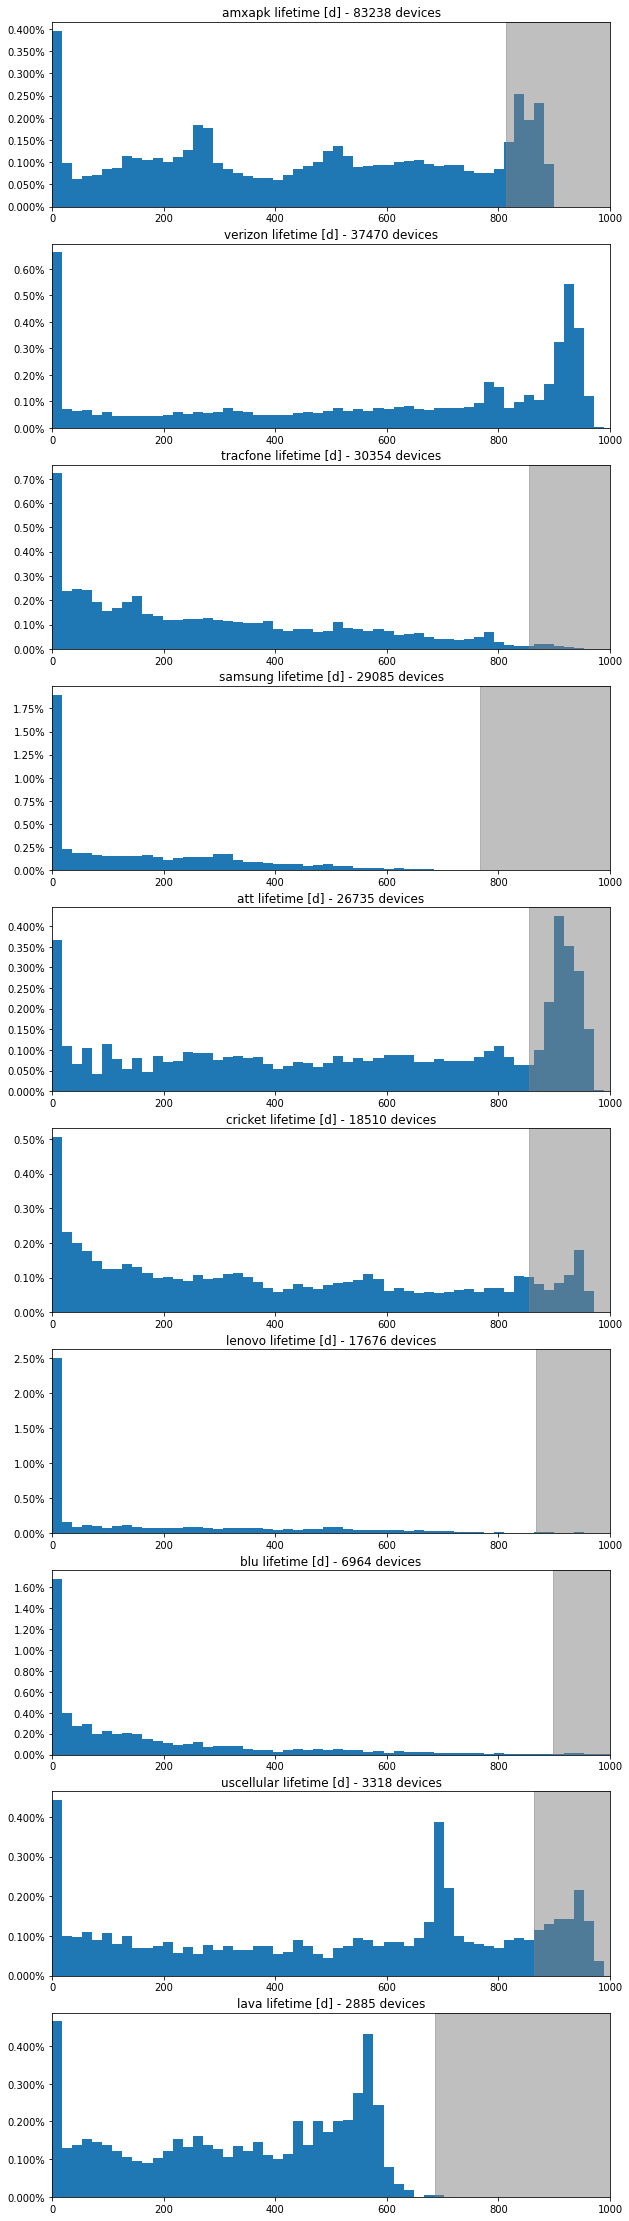

In [261]:
carriers = joined_dtid_df.groupby('c_name')['first_seen'].count().sort_values(ascending = False)

fig, ax = plt.subplots(len(carriers.index), 1, figsize = (10,4*len(carriers.index)))

for i in list(range(len(carriers.index))):
    carrier = carriers.index[i]
    filtered_lifetime = joined_dtid_df.loc[joined_dtid_df.c_name == carrier, 'lifetime']
    ax[i].set_title(f'{carrier} lifetime [d] - {carriers[carrier]} devices')
    try:
        ax[i].hist(filtered_lifetime.astype('timedelta64[D]'), bins = 100, density = True, range = [0,1800])
    except:
        print(f'ERROR with {carrier}')
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax[i].set_xlim([0,1000])
    try:
        ax[i].axvspan(tail_by_carrier.loc[carrier,'lifetime'], 1000, color = 'grey', alpha = 0.5)
    except:
        print(f'No lifetime tail agg for {carrier}')

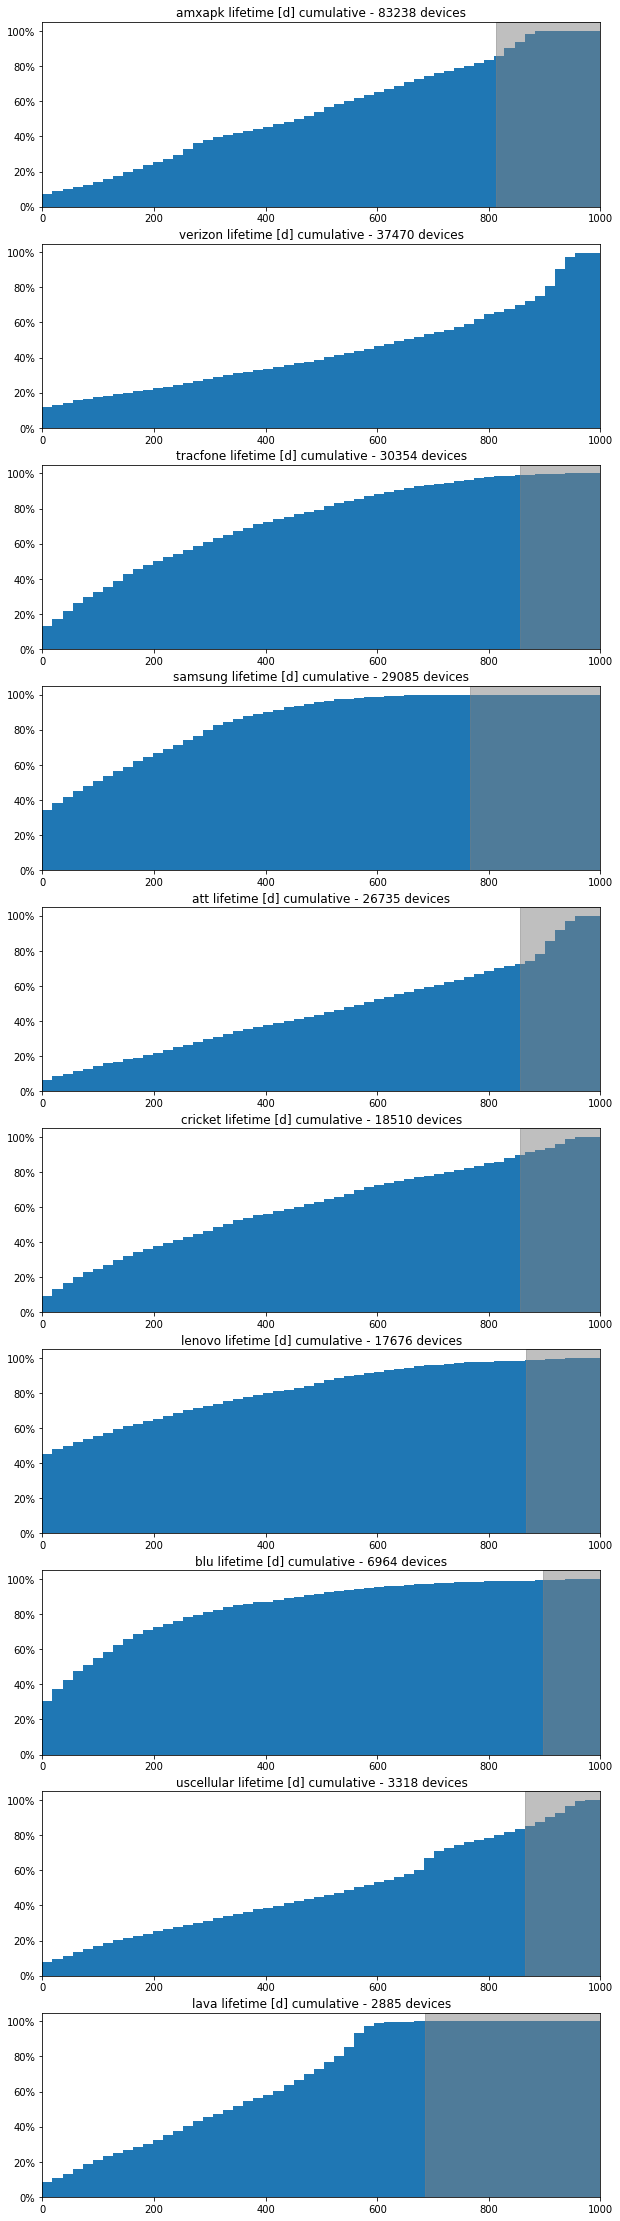

In [285]:
fig, ax = plt.subplots(len(carriers.index), 1, figsize = (10,4*len(carriers.index)))

for i in list(range(len(carriers.index))):
    carrier = carriers.index[i]
    filtered_lifetime = joined_dtid_df.loc[joined_dtid_df.c_name == carrier, 'lifetime']
    ax[i].set_title(f'{carrier} lifetime [d] cumulative - {carriers[carrier]} devices')
    try:
        ax[i].hist(filtered_lifetime.astype('timedelta64[D]'), bins = 100, cumulative = True, density = True, range = [0,1800])
    except:
        print(f'ERROR with {carrier}')
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax[i].set_xlim([0,1000])
    ax[i].axvspan(tail_by_carrier.loc[carrier, 'lifetime'], 1000, color = 'grey', alpha = 0.5)

In [236]:
bins = [pd.Timedelta(days = i*10) for i in range(102)]     
labels = [i*10 for i in range(101)]

joined_dtid_df['lifetime_binned'] = pd.cut(joined_dtid_df['lifetime'], bins, labels=labels)

joined_dtid_df_binned = joined_dtid_df.pivot_table(values = 'lifetime', index = 'lifetime_binned', columns = 'c_name', aggfunc='count', margins = True)
joined_dtid_df_binned_sov = 100*joined_dtid_df_binned.div(joined_dtid_df_binned.iloc[-1], axis=1).iloc[:-1, :-1]
joined_dtid_df_binned_cum_sov = joined_dtid_df_binned_sov.cumsum()
joined_dtid_df_binned_cum_sov




c_name               amxapk         att         blu     cricket        lava  \
lifetime_binned                                                               
0                  4.273651    4.271911   23.564504    5.865279    6.123163   
10                 5.114370    5.158247   28.292319    8.269441    7.837649   
20                 5.937880    5.744066   31.901566   10.585980    8.992302   
30                 7.100628    7.334145   36.331096   12.940854   10.496851   
40                 7.705355    7.961808   39.179717   15.027382   11.966410   
...                     ...         ...         ...         ...         ...   
960              100.000000   99.828819   99.925429   99.945235  100.000000   
970              100.000000  100.000000   99.970172  100.000000  100.000000   
980              100.000000  100.000000   99.985086  100.000000  100.000000   
990              100.000000  100.000000  100.000000  100.000000  100.000000   
1000             100.000000  100.000000  100.000000  100.000000  100.000000   

c_name               lenovo     samsung    tracfone  uscellular     verizon  
lifetime_binned                                                              
0                 33.369084   25.948726    9.366261    5.430140    9.360173  
10                35.299638   28.756428   11.411341    7.016473   10.032087  
20                37.505027   31.462783   13.830397    8.114704   10.673834  
30                39.046789   33.459705   16.417910    8.968883   11.578861  
40                40.132726   35.479149   19.005424   10.036608   12.195925  
...                     ...         ...         ...         ...         ...  
960               99.959780  100.000000  100.000000   99.084808   99.904012  
970              100.000000  100.000000  100.000000   99.969494  100.000000  
980              100.000000  100.000000  100.000000  100.000000  100.000000  
990              100.000000  100.000000  100.000000  100.000000  100.000000  
1000             100.000000  100.000000  100.000000  100.000000  100.000000  

[101 rows x 10 columns]

Text(0.5, 1.0, 'Long Lifetime carriers - cumulative')

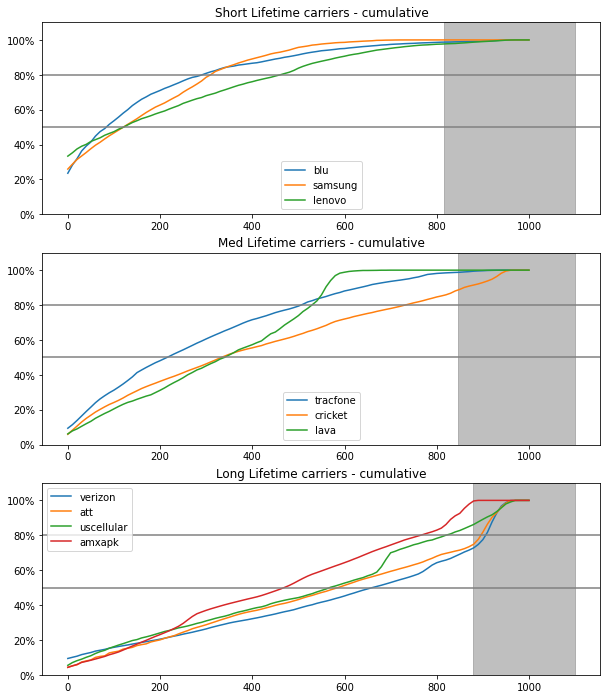

In [271]:
short_carriers = ['blu','samsung','lenovo']
med_carriers = ['tracfone','cricket','lava']
long_carriers = ['verizon','att','uscellular','amxapk']

fig, ax = plt.subplots(3,1, figsize = (10,12))
ax[0].plot(joined_dtid_df_binned_cum_sov[short_carriers])
ax[0].axhline(y=80, color = 'grey')
ax[0].axhline(y=50, color = 'grey')
weighted_table = tail_by_carrier.loc[(tail_by_carrier.index.isin(short_carriers)), ['weighted_lifetime','last_seen']].sum(axis=0)
short_carrier_tail_avg = weighted_table.iloc[0]/weighted_table.iloc[1]
ax[0].axvspan(short_carrier_tail_avg, 1100, color = 'grey', alpha = 0.5)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[0].set_ylim(0,110)
ax[0].legend(short_carriers)
ax[0].set_title('Short Lifetime carriers - cumulative')
ax[1].plot(joined_dtid_df_binned_cum_sov[med_carriers])
ax[1].axhline(y=80, color = 'grey')
ax[1].axhline(y=50, color = 'grey')
weighted_table = tail_by_carrier.loc[(tail_by_carrier.index.isin(med_carriers)), ['weighted_lifetime','last_seen']].sum(axis=0)
med_carrier_tail_avg = weighted_table.iloc[0]/weighted_table.iloc[1]
ax[1].axvspan(med_carrier_tail_avg, 1100, color = 'grey', alpha = 0.5)
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[1].set_ylim(0,110)
ax[1].legend(med_carriers)
ax[1].set_title('Med Lifetime carriers - cumulative')
ax[2].plot(joined_dtid_df_binned_cum_sov[long_carriers])
ax[2].axhline(y=80, color = 'grey')
ax[2].axhline(y=50, color = 'grey')
weighted_table = tail_by_carrier.loc[(tail_by_carrier.index.isin(long_carriers)), ['weighted_lifetime','last_seen']].sum(axis=0)
long_carrier_tail_avg = weighted_table.iloc[0]/weighted_table.iloc[1]
ax[2].axvspan(long_carrier_tail_avg, 1100, color = 'grey', alpha = 0.5)
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[2].set_ylim(0,110)
ax[2].legend(long_carriers)
ax[2].set_title('Long Lifetime carriers - cumulative')

In [169]:
filters = (joined_dtid_df.c_name == 'samsung')
joined_dtid_df[filters].pivot_table(values = 'lifetime', index = 'country', aggfunc = 'count').sort_values('lifetime', ascending = False).head(20)

lifetime
country          
br          11222
ir           1908
iq           1114
tr           1089
eg           1039
sa            893
pk            690
ar            564
co            561
mx            507
cl            467
ec            415
ma            380
pe            309
de            280
it            276
fr            272
il            244
za            231
ae            229

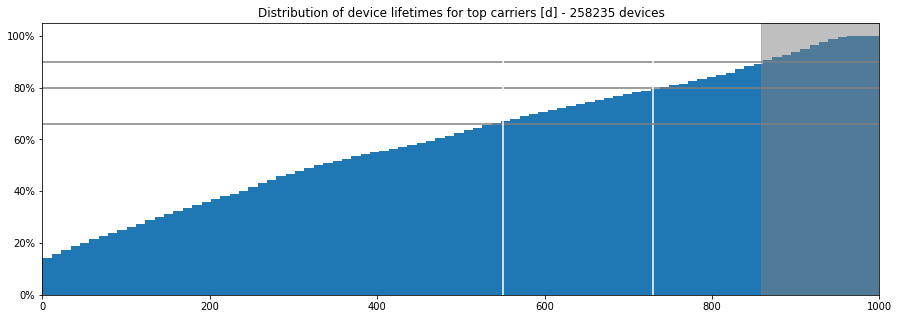

In [321]:
weighted_table = tail_by_carrier[['weighted_lifetime','last_seen']].sum(axis=0)
tail_avg = weighted_table.iloc[0]/weighted_table.iloc[1]
plt.figure(figsize = (15,5))
plt.hist(joined_dtid_df['lifetime'].astype('timedelta64[D]'), bins = 100, cumulative = True, density = True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xlim([0,1000])
plt.gca().axvspan(tail_avg, 1000, color = 'grey', alpha = 0.5)
plt.title(f'Distribution of device lifetimes for top carriers [d] - {joined_dtid_df.shape[0]} devices')
plt.gca().axhline(.90, color = 'grey')
plt.gca().axhline(.80, color = 'grey')
plt.gca().axvline(730, color = 'white')
plt.gca().axhline(.66, color = 'grey')
plt.gca().axvline(550, color = 'white')

In [297]:
tail_by_country.loc['us']

lifetime                  814
first_seen             109323
last_seen              109402
weighted_lifetime    88988922
Name: us, dtype: int64

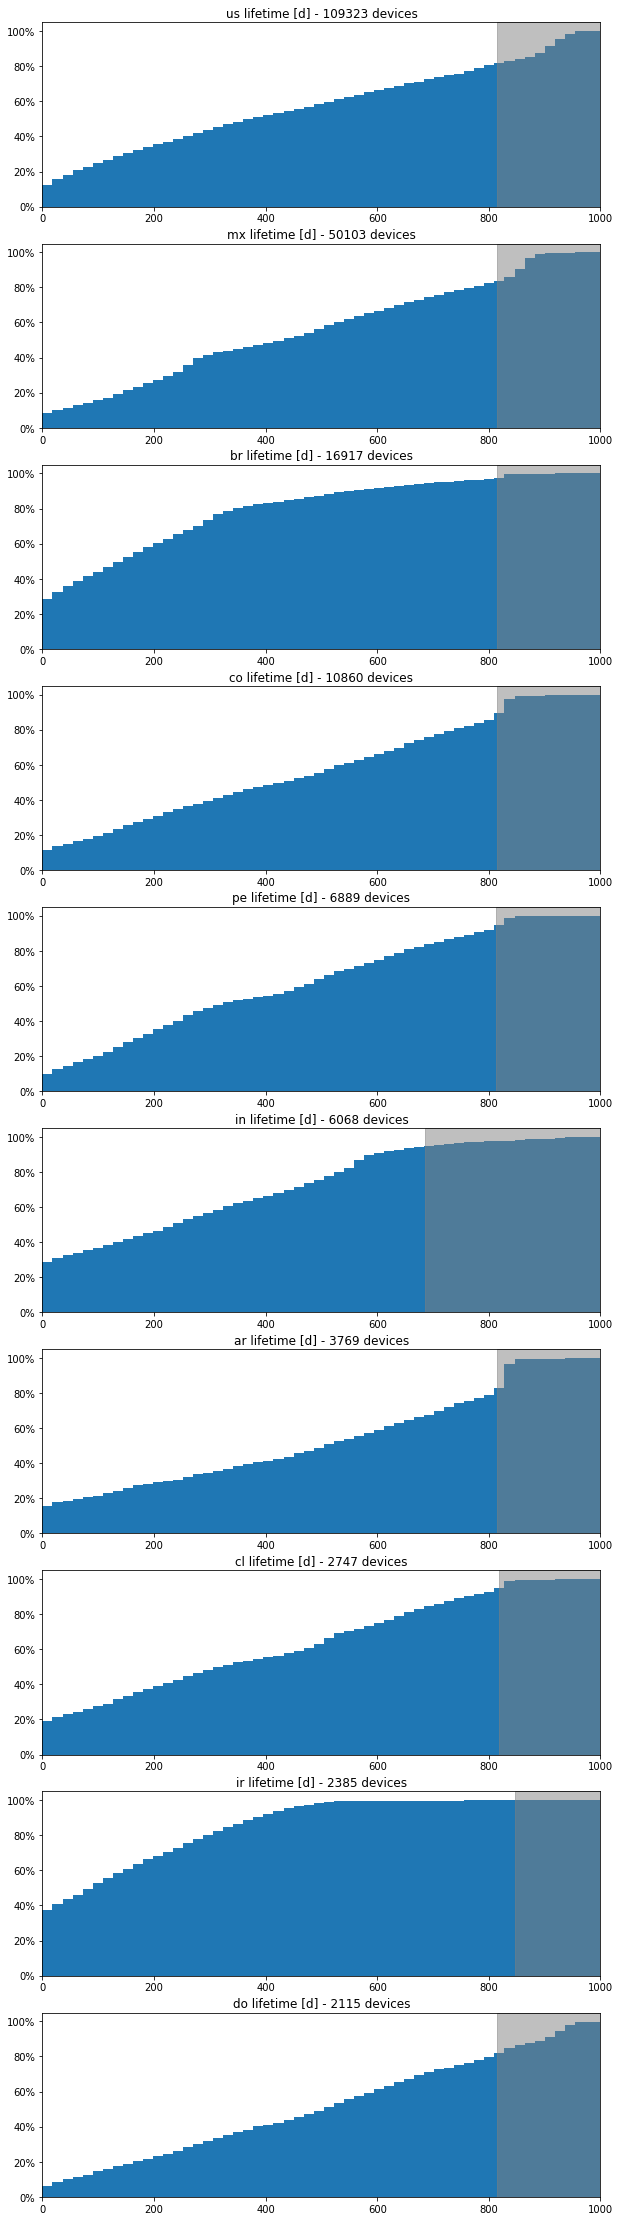

In [298]:
countries = joined_dtid_df.groupby('country')['first_seen'].count().sort_values(ascending = False)

fig, ax = plt.subplots(10, 1, figsize = (10,4*10))

for i in list(range(10)):
    country = countries.index.tolist()[i]
    filtered_lifetime = joined_dtid_df.loc[joined_dtid_df.country == country, 'lifetime']
    ax[i].set_title(f'{country} lifetime [d] - {countries[country]} devices')
    try:
        ax[i].hist(filtered_lifetime.astype('timedelta64[D]'), bins = 100, cumulative = True, density = True, range = [0,1800])
    except:
        print(f'ERROR with {country}')
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax[i].set_xlim([0,1000])
    ax[i].axvspan(tail_by_country.loc[country, 'lifetime'], 1000, color = 'grey', alpha = 0.5)
    

In [300]:
bins = [pd.Timedelta(days = i*10) for i in range(102)]     
labels = [i*10 for i in range(101)]

joined_dtid_df['lifetime_binned'] = pd.cut(joined_dtid_df['lifetime'], bins, labels=labels)

joined_dtid_df_binned = joined_dtid_df[joined_dtid_df.country.isin(countries.index[:10])].pivot_table(values = 'lifetime', index = 'lifetime_binned', columns = 'country', aggfunc='count', margins = True)
joined_dtid_df_binned_sov = 100*joined_dtid_df_binned.div(joined_dtid_df_binned.iloc[-1], axis=1).iloc[:-1, :-1]
joined_dtid_df_binned_cum_sov = joined_dtid_df_binned_sov.cumsum()
joined_dtid_df_binned_cum_sov

country                  ar          br          cl          co          do  \
lifetime_binned                                                               
0                 10.263601   21.354633   14.599924    7.674729    4.142582   
10                11.301178   23.456869   16.306409    8.569796    5.202312   
20                12.086371   25.974441   17.406143    9.579128    5.924855   
30                13.320247   27.904153   18.430034   11.016949    7.466281   
40                13.740886   29.680511   19.264316   11.721577    8.188825   
...                     ...         ...         ...         ...         ...   
960              100.000000  100.000000  100.000000  100.000000   99.759152   
970              100.000000  100.000000  100.000000  100.000000  100.000000   
980              100.000000  100.000000  100.000000  100.000000  100.000000   
990              100.000000  100.000000  100.000000  100.000000  100.000000   
1000             100.000000  100.000000  100.000000  100.000000  100.000000   

country                  in          ir          mx          pe          us  
lifetime_binned                                                              
0                 20.612061   28.392193    5.036237    6.542474    9.141726  
10                22.592259   30.994424    5.980660    7.764531   10.690202  
20                23.996400   33.131970    6.884021    8.912072   12.231174  
30                24.896490   35.687732    7.990638   10.923994   14.127611  
40                25.976598   37.081784    8.653787   11.892697   15.614185  
...                     ...         ...         ...         ...         ...  
960               99.927993  100.000000   99.995894  100.000000   99.915589  
970              100.000000  100.000000  100.000000  100.000000   99.998124  
980              100.000000  100.000000  100.000000  100.000000   99.999062  
990              100.000000  100.000000  100.000000  100.000000  100.000000  
1000             100.000000  100.000000  100.000000  100.000000  100.000000  

[101 rows x 10 columns]

Text(0.5, 1.0, 'Long Lifetime countries - cumulative')

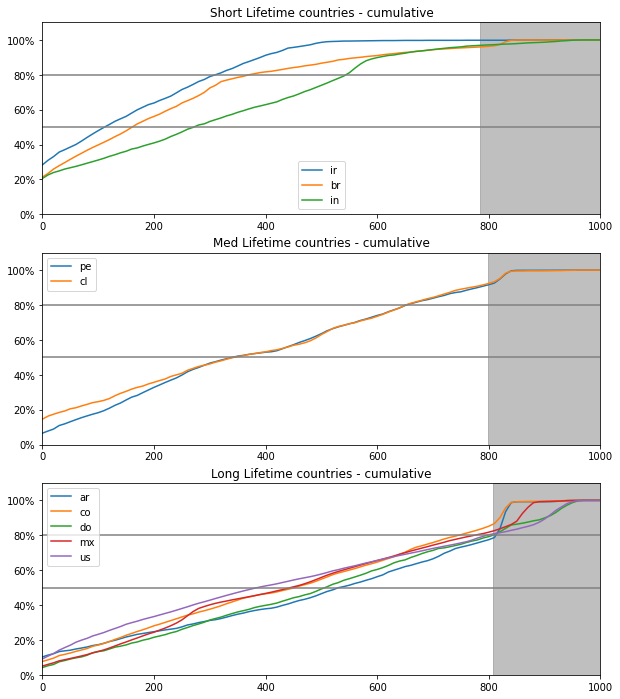

In [303]:
short_countries = ['ir','br','in']
med_countries = ['pe','cl']
long_countries = ['ar','co','do','mx','us']

fig, ax = plt.subplots(3,1, figsize = (10,12))
ax[0].plot(joined_dtid_df_binned_cum_sov[short_countries])
ax[0].axhline(y=80, color = 'grey')
ax[0].axhline(y=50, color = 'grey')
weighted_table = tail_by_country.loc[(tail_by_country.index.isin(short_countries)), ['weighted_lifetime','last_seen']].sum(axis=0)
short_country_tail_avg = weighted_table.iloc[0]/weighted_table.iloc[1]
ax[0].axvspan(short_country_tail_avg, 1100, color = 'grey', alpha = 0.5)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[0].set_ylim(0,110)
ax[0].set_xlim(0,1000)
ax[0].legend(short_countries)
ax[0].set_title('Short Lifetime countries - cumulative')
ax[1].plot(joined_dtid_df_binned_cum_sov[med_countries])
ax[1].axhline(y=80, color = 'grey')
ax[1].axhline(y=50, color = 'grey')
weighted_table = tail_by_country.loc[(tail_by_country.index.isin(med_countries)), ['weighted_lifetime','last_seen']].sum(axis=0)
med_country_tail_avg = weighted_table.iloc[0]/weighted_table.iloc[1]
ax[1].axvspan(med_country_tail_avg, 1100, color = 'grey', alpha = 0.5)
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[1].set_ylim(0,110)
ax[1].set_xlim(0,1000)
ax[1].legend(med_countries)
ax[1].set_title('Med Lifetime countries - cumulative')
ax[2].plot(joined_dtid_df_binned_cum_sov[long_countries])
ax[2].axhline(y=80, color = 'grey')
ax[2].axhline(y=50, color = 'grey')
weighted_table = tail_by_country.loc[(tail_by_country.index.isin(long_countries)), ['weighted_lifetime','last_seen']].sum(axis=0)
long_country_tail_avg = weighted_table.iloc[0]/weighted_table.iloc[1]
ax[2].axvspan(long_country_tail_avg, 1100, color = 'grey', alpha = 0.5)
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[2].set_ylim(0,110)
ax[2].set_xlim(0,1000)
ax[2].legend(long_countries)
ax[2].set_title('Long Lifetime countries - cumulative')

In [335]:
joined_dtid_df[joined_dtid_df.c_name == 'samsung'].groupby(['c_name','country']).count().sort_values('dtid', ascending = False)

dtid  last_seen  first_seen  lifetime  lifetime_binned
c_name  country                                                         
samsung br       11222      11222       11222     11222            10898
        ir        1908       1908        1908      1908             1707
        iq        1114       1114        1114      1114              995
        tr        1089       1089        1089      1089             1013
        eg        1039       1039        1039      1039              967
...                ...        ...         ...       ...              ...
        hk           1          1           1         1                1
        gd           1          1           1         1                1
        gl           1          1           1         1                1
        sz           1          1           1         1                1
        kz           1          1           1         1                1

[185 rows x 5 columns]

How many devices do we lose per month? first boots less lost.
Overall goal - addressable market for OM devices. 

Currently - push notification to any heartbeats. But we don't know how many of them are live. 